## News classification using Bert
               By: Muluemebet Ayalew
                   Sept, 2020

In this notebok, prediction of news as fake or real will be done using BERT. [BERT](https://arxiv.org/pdf/1810.04805.pdf) stands for Bidirectional Encoder Representations from Transformers. It is state of the art technique for Natural Language Processing(NLP) created and published by Google in 2018. Bidirectional means that it looks both left and right context to understand the text. It can be used for next sentence prediction, question answering, language inference and more. Here, we are going to use BERT for news classification using [transformers library](https://huggingface.co/transformers) by Hugging Face. Transformers works with  TensorFlow and PyTorch.

This notebook is created and excuted through [Google colaboratory notebook](https://colab.research.google.com/notebooks/intro.ipynb). Google Colaboratory,or Colab in short, is a free research tool provided by Google to excute python and perform machine learning tasks. It can allow us to set GPU or TPU. The setup can be done through "Runtime" tab at the top left of the notebook and then select "Change runtime type" in the dropdown menu. Then choose TPU or CPU from there.

Import important libraries 

In [4]:
import pandas as pd

In [5]:
# Important libraries

import numpy as np
import re # to use regular expression pattern 
import datetime as dt  # to parse to datetime
import string
from scipy import stats
from collections import defaultdict

#for data preprocessing
from sklearn.model_selection import train_test_split  

# to evaluate model performance
from sklearn.metrics import confusion_matrix, classification_report

# for visualization
import matplotlib.pyplot as plt
from matplotlib import rc
from pylab import rcParams
import seaborn as sns 
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


##1)Read the data
The data was downloaded from [here](https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset) as fake and true news separately. However, I downloaded the data to my local machine and read from there. Though there are different [ways to get data into Google Colab](https://towardsdatascience.com/importing-data-to-google-colab-the-clean-way-5ceef9e9e3c8), I get the data by mounting my Google Drive into Colab enviromnent.  

In [6]:
true= pd.read_csv("drive/My Drive/NLP_files/True.csv", parse_dates=["date"])     # the true news data
fake= pd.read_csv("drive/My Drive/NLP_files/Fake.csv")     # the fake news data

In [7]:
true.head(3) # the first few rows of real dataframe

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31


In [8]:
fake.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [9]:
# the size of fake and true news data sets
true.shape, fake.shape

((21417, 4), (23481, 4))

### 1.1) Add labels(fake/true) to the  dataframs

In [10]:
# create a new column called is_fake and label as 0 for true news 
true["label"]="true"
# create a new column called is_fake and label as 1 for fake news 
fake["label"]= "fake"

In [11]:
# parse the date column into datetime. 
#Since it has two datetime format, we need two formats to parse.  
def parsing_datetime(string):
    for f in ("%B %d, %Y", '%d-%b-%y', "%b %d, %Y"): # format  19-Feb-18
        try:
            return dt.datetime.strptime(string, f)
        except ValueError:
            pass
        
# parse the date column of fake dataframe into datetime
fake.date= fake.date.apply(lambda x: parsing_datetime(x))

### 1.2) Merge the real and fake dataframe

In [12]:
# Merge the fake and read dataframe
news= pd.concat([true,fake], axis=0, ignore_index=True)#.reset_index() # reset index to have unique index

In [13]:
news.head(3)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,2017-12-31,true


### 2) Data Cleaning and Preprocessing 
Remove html tags, url links, special characters, punctuations , emoji and stopwords.


In [14]:
def remove_pattern(text, patterns):
    """The function remove_pattern returns the new string with a set of patterns removed.
       Parameters:
       ------------
       text: the text from which the pattern will be removed
       patterns: is the set of patterns(iterable) we are interested to remove from the text
       """
           
    for pattern in patterns:
        new= re.sub(pattern, "", text)
        text= new 
    return new

In [15]:
# patterns to be extracted and to be removed from the data 
emoji = "[\U0001F300-\U0001F5FF\U0001F600-\U0001F64F\U0001F680-\U0001F6FF\u2600-\u26FF\u2700-\u27BF\U000024C2-\U0001F251]+"

url= re.compile("https?://\S+|www\.\S+")                     # pattern for url
html= r'<.*?>'                                               # pattern for html tag
num_with_text= r"\S*\d+\S*"                                  # pattern for digit 
reuters= r"(\s\(Reuters\))"                                  # pattern to detect Reuters, it is common word in true news
punctuation= r"[#@&%$~=\.;:\?,(){}\"\“\”\‘\'\*!\+`^<>\[\]\-]+"      #pattern for punctuations and special characters   
apostroph=r"\’s?"
# collect the patterns 
patterns=[emoji, url, html, num_with_text, apostroph,reuters,punctuation] # punctuation removed

### 2.1) Clean merged data
At this statage of data cleaning ,the emoji, url links, html tag, digits and special characters are removed.

In [16]:
# Clean the title of merged data using regular expression patterns
news_clean_title = news.title.apply(remove_pattern, patterns= patterns)
news_clean_text= news.text.apply(remove_pattern, patterns= patterns)

###2.2) Split the data into training, validating and test data

In [17]:
news["cleaned_title"]= news_clean_title
news["cleaned_text"]= news_clean_text
dicmap= {"true": 0, "fake": 1} # lable true news as 0 and fake news as 1
news["is_fake"]= news.label.apply(lambda x: dicmap[x]) 

In [18]:
news.head(2)

,title,text,subject,date,label,cleaned_title,cleaned_text,is_fake
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,2017-12-31,true,As US budget fight looms Republicans flip thei...,WASHINGTON The head of a conservative Republi...,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,2017-12-29,true,US military to accept transgender recruits on ...,WASHINGTON Transgender people will be allowed...,0


In [19]:
# copy the news to data_brt. the data to be splited into training, validating and test set
data_brt= news[["cleaned_title","cleaned_text","is_fake","label"]] 

In [20]:
data_brt.head(3)

,cleaned_title,cleaned_text,is_fake,label
0,As US budget fight looms Republicans flip thei...,WASHINGTON The head of a conservative Republi...,0,true
1,US military to accept transgender recruits on ...,WASHINGTON Transgender people will be allowed...,0,true
2,Senior US Republican senator Let Mr Mueller do...,WASHINGTON The special counsel investigation ...,0,true


In [21]:
#train_data, validate_data, test_data (80%, 10%, 10% respectively)
train_data, validate_data, test_data= np.split(data_brt.sample(frac=1, random_state=42), [ int(.8*len(news)), int(.9*len(news))])

In [22]:
# size of trainng, validating and test data
train_data.shape, validate_data.shape, test_data.shape 

((35918, 4), (4490, 4), (4490, 4))

## 3) Classification using BERT: Using Transformers library from Hugging Face

**Note**: The steps in this section are similar to the steps in [this article](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/) except some adaptation to the data at hand. We have also borrowed some codes.   

In [23]:
!pip install -qq transformers

     |████████████████████████████████| 890kB 5.4MB/s 
     |████████████████████████████████| 3.0MB 31.2MB/s 
     |████████████████████████████████| 890kB 43.1MB/s 
     |████████████████████████████████| 1.1MB 41.6MB/s 


In [24]:
# For  BERT tokenization and modeling 
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader


In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
device

device(type='cuda', index=0)

### 3.1) Tokenization
Tokenization is the process of breaking a text into smaller units called tokens. For example, sentences into list of words. BERT provids the option to keep the case of the text(upper case or lowercase) or making them uncased. In our case, the  uncased version of BERT is used. 


In [27]:
# uncased version of BERT
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [28]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME, do_lower_case=True)

In [29]:
train_data.iloc[0,0] # get a sample news title from the training data 

' BREAKING GOP Chairman Grassley Has Had Enough DEMANDS Trump Jr Testimony'

In [30]:
sample_txt=train_data.iloc[0,0]

In [31]:
# tokenizing sample text from training data 
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
  truncation=True # to truncate excess tokens to meet the maximum length
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

Parameter explanation : 

*  max_length: has integer value to pass sequency of constance length, controls the length for padding/truncation
*  add_special_tokens: has boolean value  to add special  tokens such as [CLS] to add at the start of each sentence and [SEP] to mark ending of a sentence. 
*   return_token_type_ids: has boolean value to whether to return token type IDs(list of token type ids to be fed to a model).
*   padding: activates and control padding. if set to 'max_length' Pad to a maximum length specified with the argument max_length.Creats array of 0s (pad token) and 1s (real token) called attention mask
*   return_attention_mask: Whether to return the attention mask, indicates to the model which tokens should be attended to, and which should not.
*   return_tensors:  Can be set to ‘tf’, ‘pt’ or ‘np’ to return TensorFlow tf.constant, PyTorch torch.Tensor or Numpy, respectively.
*   truncation: has boolean value to control truncation



For more parameters and detailed explanations please refere [here](https://huggingface.co/transformers/main_classes/tokenizer.html#transformers.PreTrainedTokenizer).  




In [32]:
encoding["input_ids"]

tensor([[  101,  4911,  2175,  2361,  3472,  5568,  3051,  2038,  2018,  2438,
          7670,  8398,  3781, 10896,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0]])

In [33]:
encoding["attention_mask"]# shows 1 for real token and 0 for pad tokens 

tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

To set the max_length, let us look at token length in the news title.

In [34]:
token_length=[] # place holder to count the number of tokens in news 
for ttl in data_brt.cleaned_title:
  tokens = tokenizer.encode(ttl, max_length=512, truncation=True)
  token_length.append(len(tokens)) # list of token count of each news title

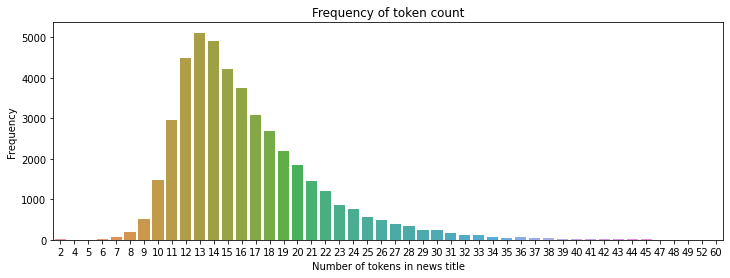

In [35]:
plt.figure(figsize=(12,4))
#sns.distplot(token_length)
sns.countplot(token_length)
plt.title("Frequency of token count")
plt.xlabel("Number of tokens in news title")
plt.ylabel("Frequency")
plt.show()

In [36]:
# see the median, 95% quantile and maximum token count
print("median number of tokens = {},95% quantile = {}, maximum number of tokens = {}"\
      .format(np.median(token_length),np.quantile(token_length,0.95),np.max(token_length)))

median number of tokens = 15.0,95% quantile = 26.0, maximum number of tokens = 60


To be safe, we can set the maximum length as 60. But we can also set lesser number as majority of token counts are below 30.

In [37]:
max_len= 60  # maximum length

In [38]:
# define a class that can tokenize the data
class NewsDataset(Dataset):
  def __init__(self, text, targets, tokenizer, max_len):
    self.text = text
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.text)
  def __getitem__(self, item):
    row = str(self.text[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      row,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      return_attention_mask=True,
      truncation=True, # to truncate excess tokens to meet the maximum length
      return_tensors='pt',
    )
    return {
      'row_text': row,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

#### Data loader
The following function is specifically defined for only the tittle of the news . For the text of the news, use similar approach but the input data has to be the column "cleaned_text".

In [39]:
# cleate dataloader for news title
def create_data_loader(data, tokenizer, max_len, batch_size):
    ds = NewsDataset(
    text=data.cleaned_title.to_numpy(),
    targets=data.is_fake.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader(ds,batch_size=batch_size, num_workers=4)

BATCH_SIZE = 16
train_data_loader = create_data_loader(train_data, tokenizer, max_len, BATCH_SIZE)
val_data_loader = create_data_loader(validate_data, tokenizer, max_len, BATCH_SIZE)
test_data_loader = create_data_loader(test_data, tokenizer, max_len, BATCH_SIZE)

In [40]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['row_text', 'input_ids', 'attention_mask', 'targets'])

In [41]:
# the shape of input_ids, attention_mask and targets for a batch
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 60])
torch.Size([16, 60])
torch.Size([16])


Let us see how the result looks like:

In [42]:
data["row_text"][0:3] # the first three news title in training data

[' BREAKING GOP Chairman Grassley Has Had Enough DEMANDS Trump Jr Testimony',
 ' Failed GOP Candidates Remembered In Hilarious Mocking Eulogies VIDEO',
 ' Mike Pence New DC Neighbors Are HILARIOUSLY Trolling Him For Being A Homophobic Bigot']

In [43]:
print(data['input_ids'][:3]) # the first three news input_ids in training data

tensor([[  101,  4911,  2175,  2361,  3472,  5568,  3051,  2038,  2018,  2438,
          7670,  8398,  3781, 10896,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  3478,  2175,  2361,  5347,  4622,  1999, 26316, 19545,  7327,
         21615,  2678,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0],
        [  101,  3505,  7279,  3401,  2047,  5887,

In [44]:
print(data['targets'][:3]) # target value for a batch of 16

tensor([1, 1, 1])


In [45]:
# We can confirm the above result from the training dataframe
train_data.head(3)

,cleaned_title,cleaned_text,is_fake,label
22216,BREAKING GOP Chairman Grassley Has Had Enough...,Donald Trump s White House is in chaos and the...,1,fake
27917,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,1,fake
25007,Mike Pence New DC Neighbors Are HILARIOUSLY T...,Mike Pence is a huge homophobe He supports exg...,1,fake


### 3.2) Modeling using BERT

BERT Base-uncase pretrained model was used to train and validate the data. 


In [46]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [47]:
# for the sample data
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

Last_hidden state in this case contians each token in a news and their corresponding hidden units of the last layer in the feedforward-networks whereas pooled_output is the summary of a news title on last_hidden_state. 

In [48]:
last_hidden_state.shape #  the number of hidden units in the feedforward-networks=768

torch.Size([1, 32, 768])

In [49]:
pooled_output.shape

torch.Size([1, 768])

In [50]:
class NewsClassifier(nn.Module):
  def __init__(self, n_classes): 
    super(NewsClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [51]:
#create classifier instance and move it to the GPU
model = NewsClassifier(2) # we have two classes, fake and real
model = model.to(device)

In [52]:
# move the batch of training data to GPU
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 60])
torch.Size([16, 60])


In [53]:
# predicted probabilities from the trained model using softmax function
nn.functional.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.3372, 0.6628],
        [0.3495, 0.6505],
        [0.4470, 0.5530],
        [0.5714, 0.4286],
        [0.4157, 0.5843],
        [0.5251, 0.4749],
        [0.4097, 0.5903],
        [0.3171, 0.6829],
        [0.5494, 0.4506],
        [0.2329, 0.7671],
        [0.3344, 0.6656],
        [0.3892, 0.6108],
        [0.4278, 0.5722],
        [0.4010, 0.5990],
        [0.4201, 0.5799],
        [0.4491, 0.5509]], device='cuda:0', grad_fn=<SoftmaxBackward>)

### 3.3) Fine-tuning BERT model

Recommendations for fine-tuning by BERT's author:
*   Batch size: 16, 32: increasing the batch size reduces the training time but gives lower accuracy
*   Learning rate (Adam): 5e-5, 3e-5, 2e-5
*   Number of epochs: 2, 3, 4

Cross intropy is the measure of the performance of classification obtained by compairing the actual probablity with the  predicted probablity(for more detail explanation please refer [here](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html#:~:text=Cross-entropy%20loss%2C%20or%20log%20loss%2C%20measures%20the%20performance,the%20predicted%20probability%20diverges%20from%20the%20actual%20label.))

In [54]:
#Training 
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
  )
loss_fn = nn.CrossEntropyLoss().to(device)

In [55]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0 
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1) #get the maximum probablity for prediction
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets) # number of correct predictions
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)  # accuracy

In [56]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1) # take the maximum 
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)  # accuracy 

In [57]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(train_data)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(validate_data)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.12456744883378257 accuracy 0.9616069937078903
Val   loss 0.12029871357005384 accuracy 0.9706013363028954

Epoch 2/4
----------
Train loss 0.03895378594950262 accuracy 0.990255582159363
Val   loss 0.1078015402271897 accuracy 0.978619153674833

Epoch 3/4
----------
Train loss 0.011100436823252917 accuracy 0.9978005456873991
Val   loss 0.12340181627174304 accuracy 0.9804008908685969

Epoch 4/4
----------
Train loss 0.00548870717752439 accuracy 0.9989420346344452
Val   loss 0.13874070685930334 accuracy 0.9799554565701559

CPU times: user 17min 37s, sys: 3min 27s, total: 21min 4s
Wall time: 21min 21s


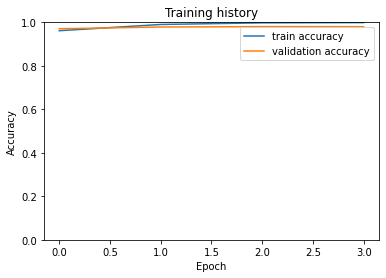

In [58]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [59]:
# model = NewsClassifier(2) # len(class_names)
#model.load_state_dict(torch.load('best_model_state.bin'))
# model = model.to(device)


## Validate with test data 

In [60]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(test_data)
)
test_acc.item()

0.9848552338530067

In [61]:
# A fuction that returns the actual text,
# prediction , prediction probablity and real labeling
def get_predictions(model, data_loader):
  model = model.eval()
  news_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["row_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      news_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return news_texts, predictions, prediction_probs, real_values

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
y_news_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [64]:
print(classification_report(y_test, y_pred, target_names=["true","fake"]))

              precision    recall  f1-score   support

        true       0.99      0.98      0.98      2141
        fake       0.98      0.99      0.99      2349

    accuracy                           0.98      4490
   macro avg       0.98      0.98      0.98      4490
weighted avg       0.98      0.98      0.98      4490



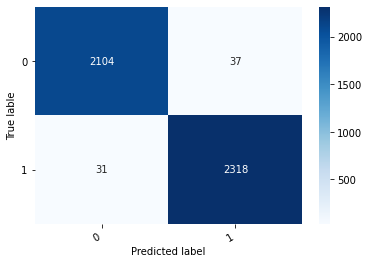

In [65]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True lable')
  plt.xlabel('Predicted label');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=[0,1], columns=[0,1]) # [0,1] is class name
show_confusion_matrix(df_cm)

In [66]:
y_news_texts[1]

'China says US should respect concerns on Taiwan'

In [67]:
y_test[1]

tensor(0)

In [68]:
idx = 2
class_names= ["true","fake"]
news_text_ttl = y_news_texts[idx]
true_label = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})
print("\n".join(wrap(news_text_ttl)))
print()
print(f'True prediction: {class_names[true_label]}')

HOW  ILLEGAL KIDS Have Been Able To Avoid Deportation

True prediction: fake


In [69]:
y_pred[2] #prediction

tensor(1)

### Predicting on news titles from Snopes 
The model is used to predict twenty news from [Snopes](https://www.snopes.com/),a fact checking website.  It has news rated as false, true, mixed and so on. To test the model, the titles from the 2016/2017 news archive were collected from Snopes. This is because the data at hand was from 2015 to 2018. The current news might not be a good test as news in 2020 might be dominated by current issues such as covid-19. Thus, the older news was considered. From a total of  the twenty news title, half of them were fake news and rest were true news.

In [70]:
snopes_data= ["Is This James Earl Jones Dressed as Darth Vader", 
"David Rockefeller's Sixth Heart Transplant Successful at Age 99", 
"Did Bloomington Police Discover Over 200 Penises During Raid at a Mortician's Home?", 
"Is the Trump Administration Price Gouging Puerto Rico Evacuees and Seizing Passports?",
"2017 Tainted Halloween Candy Reports 11/5/2014", 
"Did President Trump Say Pedophiles Will Get the Death Penalty?", 
"Michelle Obama Never Placed Her Hand Over Her Heart During the National Anthem?",
"Katy Perry Reveals Penchant for Cannibalism?" ,
"Is a Virginia Church Ripping Out an 'Offensive' George Washington Plaque?", 
"Were Scientists Caught Tampering with Raw Data to Exaggerate Sea Level Rise?",
"Did Trump Retweet a Cartoon of a Train Hitting a CNN Reporter?",
"Did Pipe-Bombing Suspect Cesar Sayoc Attend Donald Trump Rallies?",
"Did President Trump’s Grandfather Beg the Government of Bavaria Not to Deport Him?",
"Did Gun Violence Kill More People in U.S. in 9 Weeks than U.S. Combatants Died on D-Day?",
 "Did the Florida Shooter’s Instagram Profile Picture Feature a ‘MAGA’ Hat?",
"Wisconsin Department of Natural Resources Removes References to ‘Climate’ from Web Site",
 "Hillary Clinton Referenced RFK Assassination as Reason to Continue 2008 Campaign",
  "Did Richard Nixon Write a Letter Predicting Donald Trump’s Success in Politics?", 
"Did a Twitter User Jeopardize Her NASA Internship by Insulting a Member of the National Space Council?",
"Did WaPo Headline Call IS Leader al-Baghdadi an ‘Austere Religious Scholar’?"]  

label_actual = ["fake", "fake","fake","fake","fake","mixed", "fake","fake","mostly_false","fake","true",
               "true", "true","true","true","true","true","true","true","true"] # rated by Snopes
label_adjusted = ["fake", "fake","fake","fake","fake","fake", "fake","fake","fake","fake","true","true",
                  "true","true","true","true","true","true","true","true"]  # adjusted to fake or true

Clean the news in the same way as we cleaded the training data.

In [108]:
snopes_pred=[]
count_true_pred=0
for pos,ttl in enumerate(snopes_data):
  ttl= remove_pattern(ttl, patterns) # clean the title
  encoded_snopes = tokenizer.encode_plus(
    ttl,
    max_length=max_len,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    truncation=True,
    return_tensors='pt',
  )

  input_ids = encoded_snopes['input_ids'].to(device)
  attention_mask = encoded_snopes['attention_mask'].to(device)
  output = model(input_ids, attention_mask)
  _, prediction = torch.max(output, dim=1)
  pred_label=class_names[prediction]  #  prediction class
  snopes_pred.append(pred_label)

  # compaire the predicted and actual class label
  count_true_pred += (pred_label==label_adjusted[pos])
  
  
print(f'Snopes news title: {snopes_data}')
print(f'Prediction  : {snopes_pred}')
print(f'accuracy  : {count_true_pred/len(snopes_data)}')

/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:1770: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Snopes news title: ['Is This James Earl Jones Dressed as Darth Vader', "David Rockefeller's Sixth Heart Transplant Successful at Age 99", "Did Bloomington Police Discover Over 200 Penises During Raid at a Mortician's Home?", 'Is the Trump Administration Price Gouging Puerto Rico Evacuees and Seizing Passports?', '2017 Tainted Halloween Candy Reports 11/5/2014', 'Did President Trump Say Pedophiles Will Get the Death Penalty?', 'Michelle Obama Never Placed Her Hand Over Her Heart During the National Anthem?', 'Katy Perry Reveals Penchant for Cannibalism?', "Is a Virginia Church Ripping Out an 'Offensive' George Washington Plaque?", 'Were Scientists Caught Tampering with Raw Data to Exaggerate Sea Level Rise?', 'Did Trump Retweet a Cartoon of a Train Hitting a CNN Reporter?', 'Did Pipe-Bombing Suspect Cesar Sayoc Attend Donald Trump Rallies?', 'Did President Trump’s Grandfather Beg the Government of Bavaria Not to Deport Him?', 'Did Gun Violence Kill More People in U.S. in 9 Weeks than U.

### Summary 
The BERT model has better accuracy than other models done by word count, tfidf and word2vec. It accuracy of test data was improved to 0.98 from accuracies obtained by other models(0.93-0.94). Though due to the capacity limit, we could not be able to predict using news text, we expect the same better performance than the corresponding models. This is left for forther reaserch.  